In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap, Map
from gammapy.spectrum.models import PowerLaw
from gammapy.image.models import SkyGaussian
from gammapy.cube.models import SkyModel, SkyModels, BackgroundModel
from gammapy.cube import MapDataset, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.utils.fitting import Fit
from gammapy.data import FixedPointingInfo

import emcee

ModuleNotFoundError: No module named 'emcee'

In [2]:
!gammapy info --no-envvar --no-dependencies --no-system

Traceback (most recent call last):
  File "/Users/facero/Documents/Work/Program/Anaconda/envs/cta/bin/gammapy", line 11, in <module>
    load_entry_point('gammapy', 'console_scripts', 'gammapy')()
  File "/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg/pkg_resources/__init__.py", line 565, in load_entry_point
  File "/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg/pkg_resources/__init__.py", line 2598, in load_entry_point
  File "/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg/pkg_resources/__init__.py", line 2258, in load
  File "/Users/facero/Documents/Work/Program/Anaconda/envs/cta/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg/pkg_resources/__init__.py", line 2264, in resolve
  File "/Users/facero/Documents/Work/Program/gammapy/gammapy/gammapy/scripts/main.py", line 190, in <module>
    

## Simulate an observation


In [3]:
filename = (
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)
irfs = load_cta_irfs(filename)

In [4]:
# Define sky model to simulate the data
spatial_model = SkyGaussian(lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.3 deg")
spectral_model = PowerLaw(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model
)
print(sky_model)

SkyModel

Parameters: 

	   name     value   error      unit         min    max frozen
	--------- --------- ----- -------------- --------- --- ------
	    lon_0 2.000e-01   nan            deg       nan nan  False
	    lat_0 1.000e-01   nan            deg       nan nan  False
	    sigma 3.000e-01   nan            deg 0.000e+00 nan  False
	    index 3.000e+00   nan                      nan nan  False
	amplitude 1.000e-11   nan cm-2 s-1 TeV-1       nan nan  False
	reference 1.000e+00   nan            TeV       nan nan   True


In [5]:
# Define map geometry
axis = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(5, 4), coordsys="GAL", axes=[axis]
)

In [6]:
# Define some observation parameters
# We read in the pointing info from one of the 1dc event list files as an example
pointing = FixedPointingInfo.read("$GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_110380.fits")

livetime = 1 * u.hour
offset_max = 2 * u.deg
offset = Angle("2 deg")

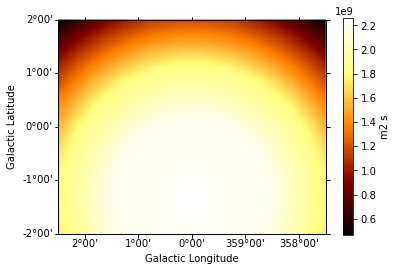

In [7]:
exposure = make_map_exposure_true_energy(
    pointing=pointing.radec, livetime=livetime, aeff=irfs["aeff"], geom=geom
)
exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

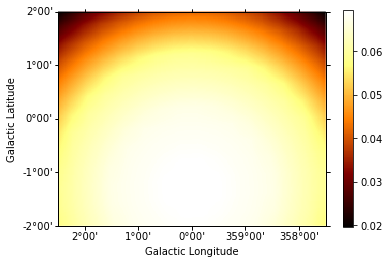

In [8]:
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom
)
background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

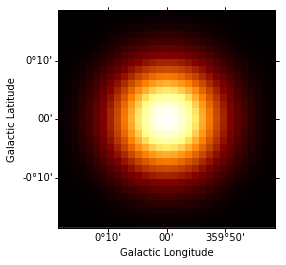

In [9]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=0.3 * u.deg)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

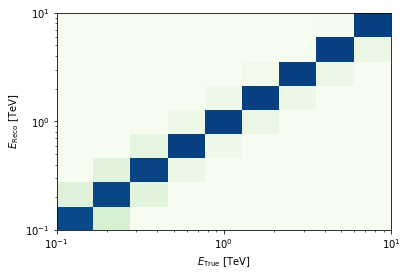

In [10]:
energy = axis.edges * axis.unit
edisp = irfs["edisp"].to_energy_dispersion(
    offset, e_reco=energy, e_true=energy
)
edisp.plot_matrix();

In [11]:
evaluator_src = MapEvaluator(   
    model=sky_model,
    exposure=exposure,
    psf=psf_kernel,
    edisp=edisp,
)
npred_src = evaluator_src.compute_npred()
background_model = BackgroundModel(background)
npred_bkg = background_model.evaluate()

npred_data = npred_src.data + npred_bkg.data
npred_map = WcsNDMap(geom, npred_data)

In [12]:
# This one line is the core of how to simulate data when
# using binned simulation / analysis: you Poisson fluctuate
# npred to obtain simulated observed counts.
# Compute counts as a Poisson fluctuation
rng = np.random.RandomState(seed=42)
counts = rng.poisson(npred_data)
counts_map = WcsNDMap(geom, counts)

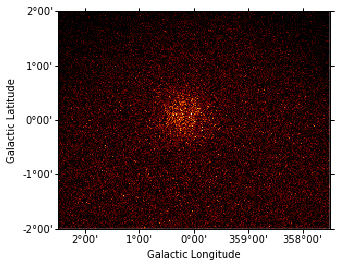

In [13]:
counts_map.sum_over_axes().plot();

## Fit the data with MCMC

Now let's analyse the simulated data.
Here we just fit it again with the same model we had before as a starting point.
The data that would be needed are the following: 
- counts_map, background_model, psf, exposure